In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/network-intrusion-detection/Train_data.csv
/kaggle/input/network-intrusion-detection/Test_data.csv


In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import multiprocessing
import itertools
import warnings

from collections import Counter
from pandas.api.types import is_numeric_dtype

# Machine Learning Models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import RFE
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, 
    AdaBoostClassifier, 
    VotingClassifier, 
    GradientBoostingClassifier,
    BaggingClassifier, 
    ExtraTreesClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Deep Learning (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Metrics & Evaluation
from sklearn.metrics import (
    accuracy_score, confusion_matrix, precision_score, recall_score, 
    f1_score, roc_auc_score, classification_report, precision_recall_curve,
    r2_score, mean_squared_error
)

# Handling Imbalanced Data
from imblearn.over_sampling import SMOTE, ADASYN

# Suppress warnings
warnings.filterwarnings("ignore")


# Load & Read The Training Dataset

In [6]:
train = pd.read_csv("/kaggle/input/network-intrusion-detection/Train_data.csv")

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   protocol_type                25192 non-null  object 
 2   service                      25192 non-null  object 
 3   flag                         25192 non-null  object 
 4   src_bytes                    25192 non-null  int64  
 5   dst_bytes                    25192 non-null  int64  
 6   land                         25192 non-null  int64  
 7   wrong_fragment               25192 non-null  int64  
 8   urgent                       25192 non-null  int64  
 9   hot                          25192 non-null  int64  
 10  num_failed_logins            25192 non-null  int64  
 11  logged_in                    25192 non-null  int64  
 12  num_compromised              25192 non-null  int64  
 13  root_shell      

In [8]:
train.shape

(25192, 42)

In [9]:
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [10]:
train.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,25192.000000,2.519200e+04,2.519200e+04,25192.000000,25192.000000,25192.00000,25192.000000,25192.000000,25192.000000,25192.000000,...,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000
mean,305.054104,2.433063e+04,3.491847e+03,0.000079,0.023738,0.00004,0.198039,0.001191,0.394768,0.227850,...,182.532074,115.063036,0.519791,0.082539,0.147453,0.031844,0.285800,0.279846,0.117800,0.118769
std,2686.555640,2.410805e+06,8.883072e+04,0.008910,0.260221,0.00630,2.154202,0.045418,0.488811,10.417352,...,98.993895,110.646850,0.448944,0.187191,0.308367,0.110575,0.445316,0.446075,0.305869,0.317333
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,84.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,255.000000,61.000000,0.510000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.790000e+02,5.302500e+02,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42862.000000,3.817091e+08,5.151385e+06,1.000000,3.000000,1.00000,77.000000,4.000000,1.000000,884.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
train.describe(include='object')

,protocol_type,service,flag,class
count,25192,25192,25192,25192
unique,3,66,11,2
top,tcp,http,SF,normal
freq,20526,8003,14973,13449


# Exploratory Data Analysis (EDA)

In [12]:
train['class'].value_counts()

class
normal     13449
anomaly    11743
Name: count, dtype: int64

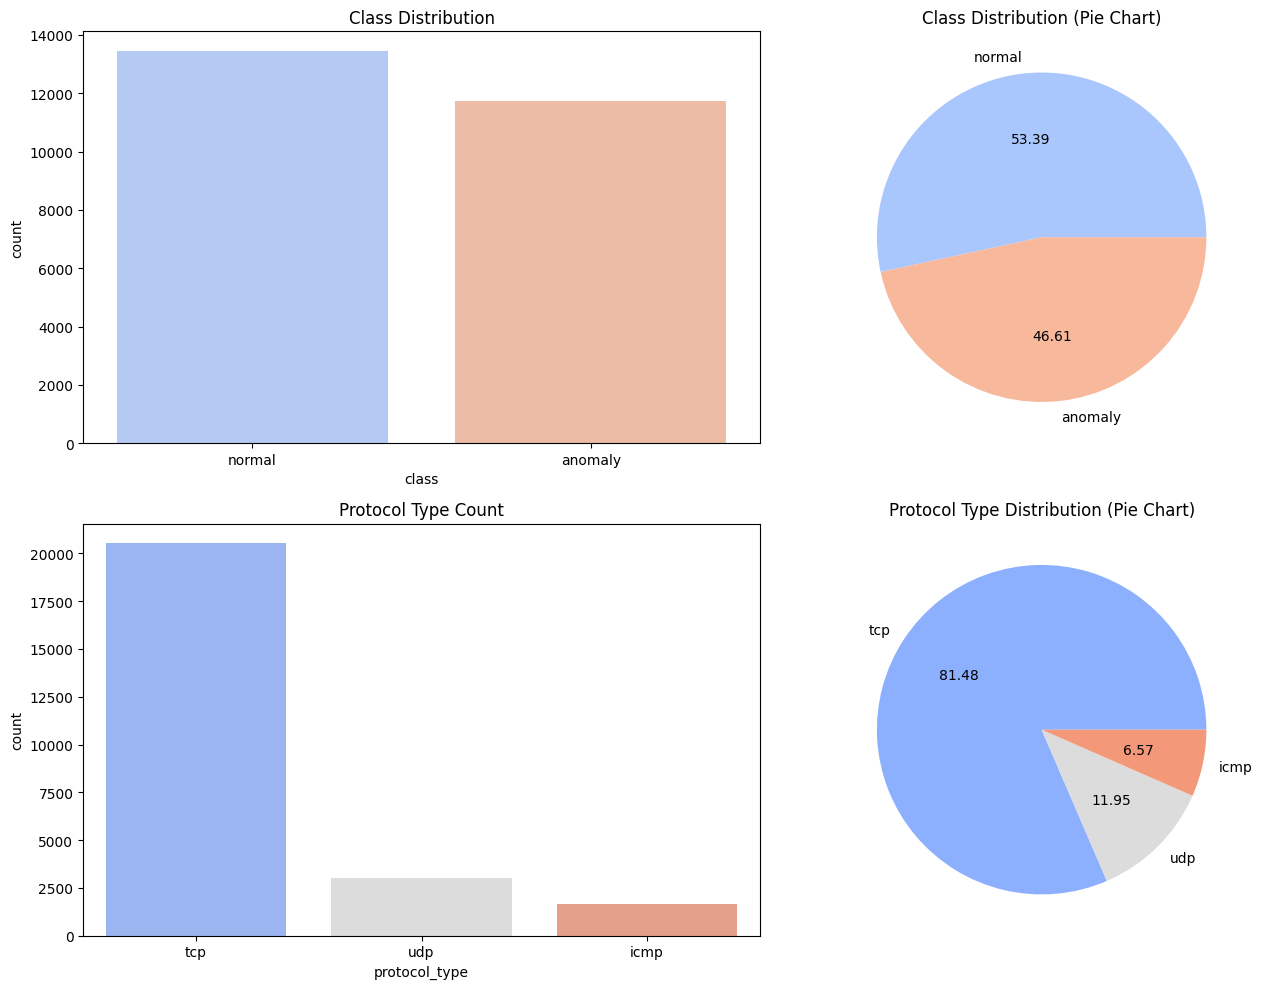

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Creating a 2x2 grid instead of 2x3

# Define the color palette
palette = "coolwarm"

# First plot: Bar chart of class distribution
sns.countplot(ax=axes[0, 0], x=train['class'], palette=palette)
axes[0, 0].set_title("Class Distribution")

# Second plot: Pie chart of class distribution
axes[0, 1].pie(train['class'].value_counts(), labels=train['class'].value_counts().index, autopct="%0.2f", colors=sns.color_palette(palette, n_colors=2))
axes[0, 1].set_title("Class Distribution (Pie Chart)")

# Third plot: Bar chart of protocol type
sns.countplot(ax=axes[1, 0], x=train['protocol_type'], palette=palette)
axes[1, 0].set_title("Protocol Type Count")

# Fourth plot: Pie chart of protocol type
axes[1, 1].pie(train['protocol_type'].value_counts(), labels=train['protocol_type'].value_counts().index, autopct="%0.2f", colors=sns.color_palette(palette, n_colors=3))
axes[1, 1].set_title("Protocol Type Distribution (Pie Chart)")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


# EDA - Visualisation

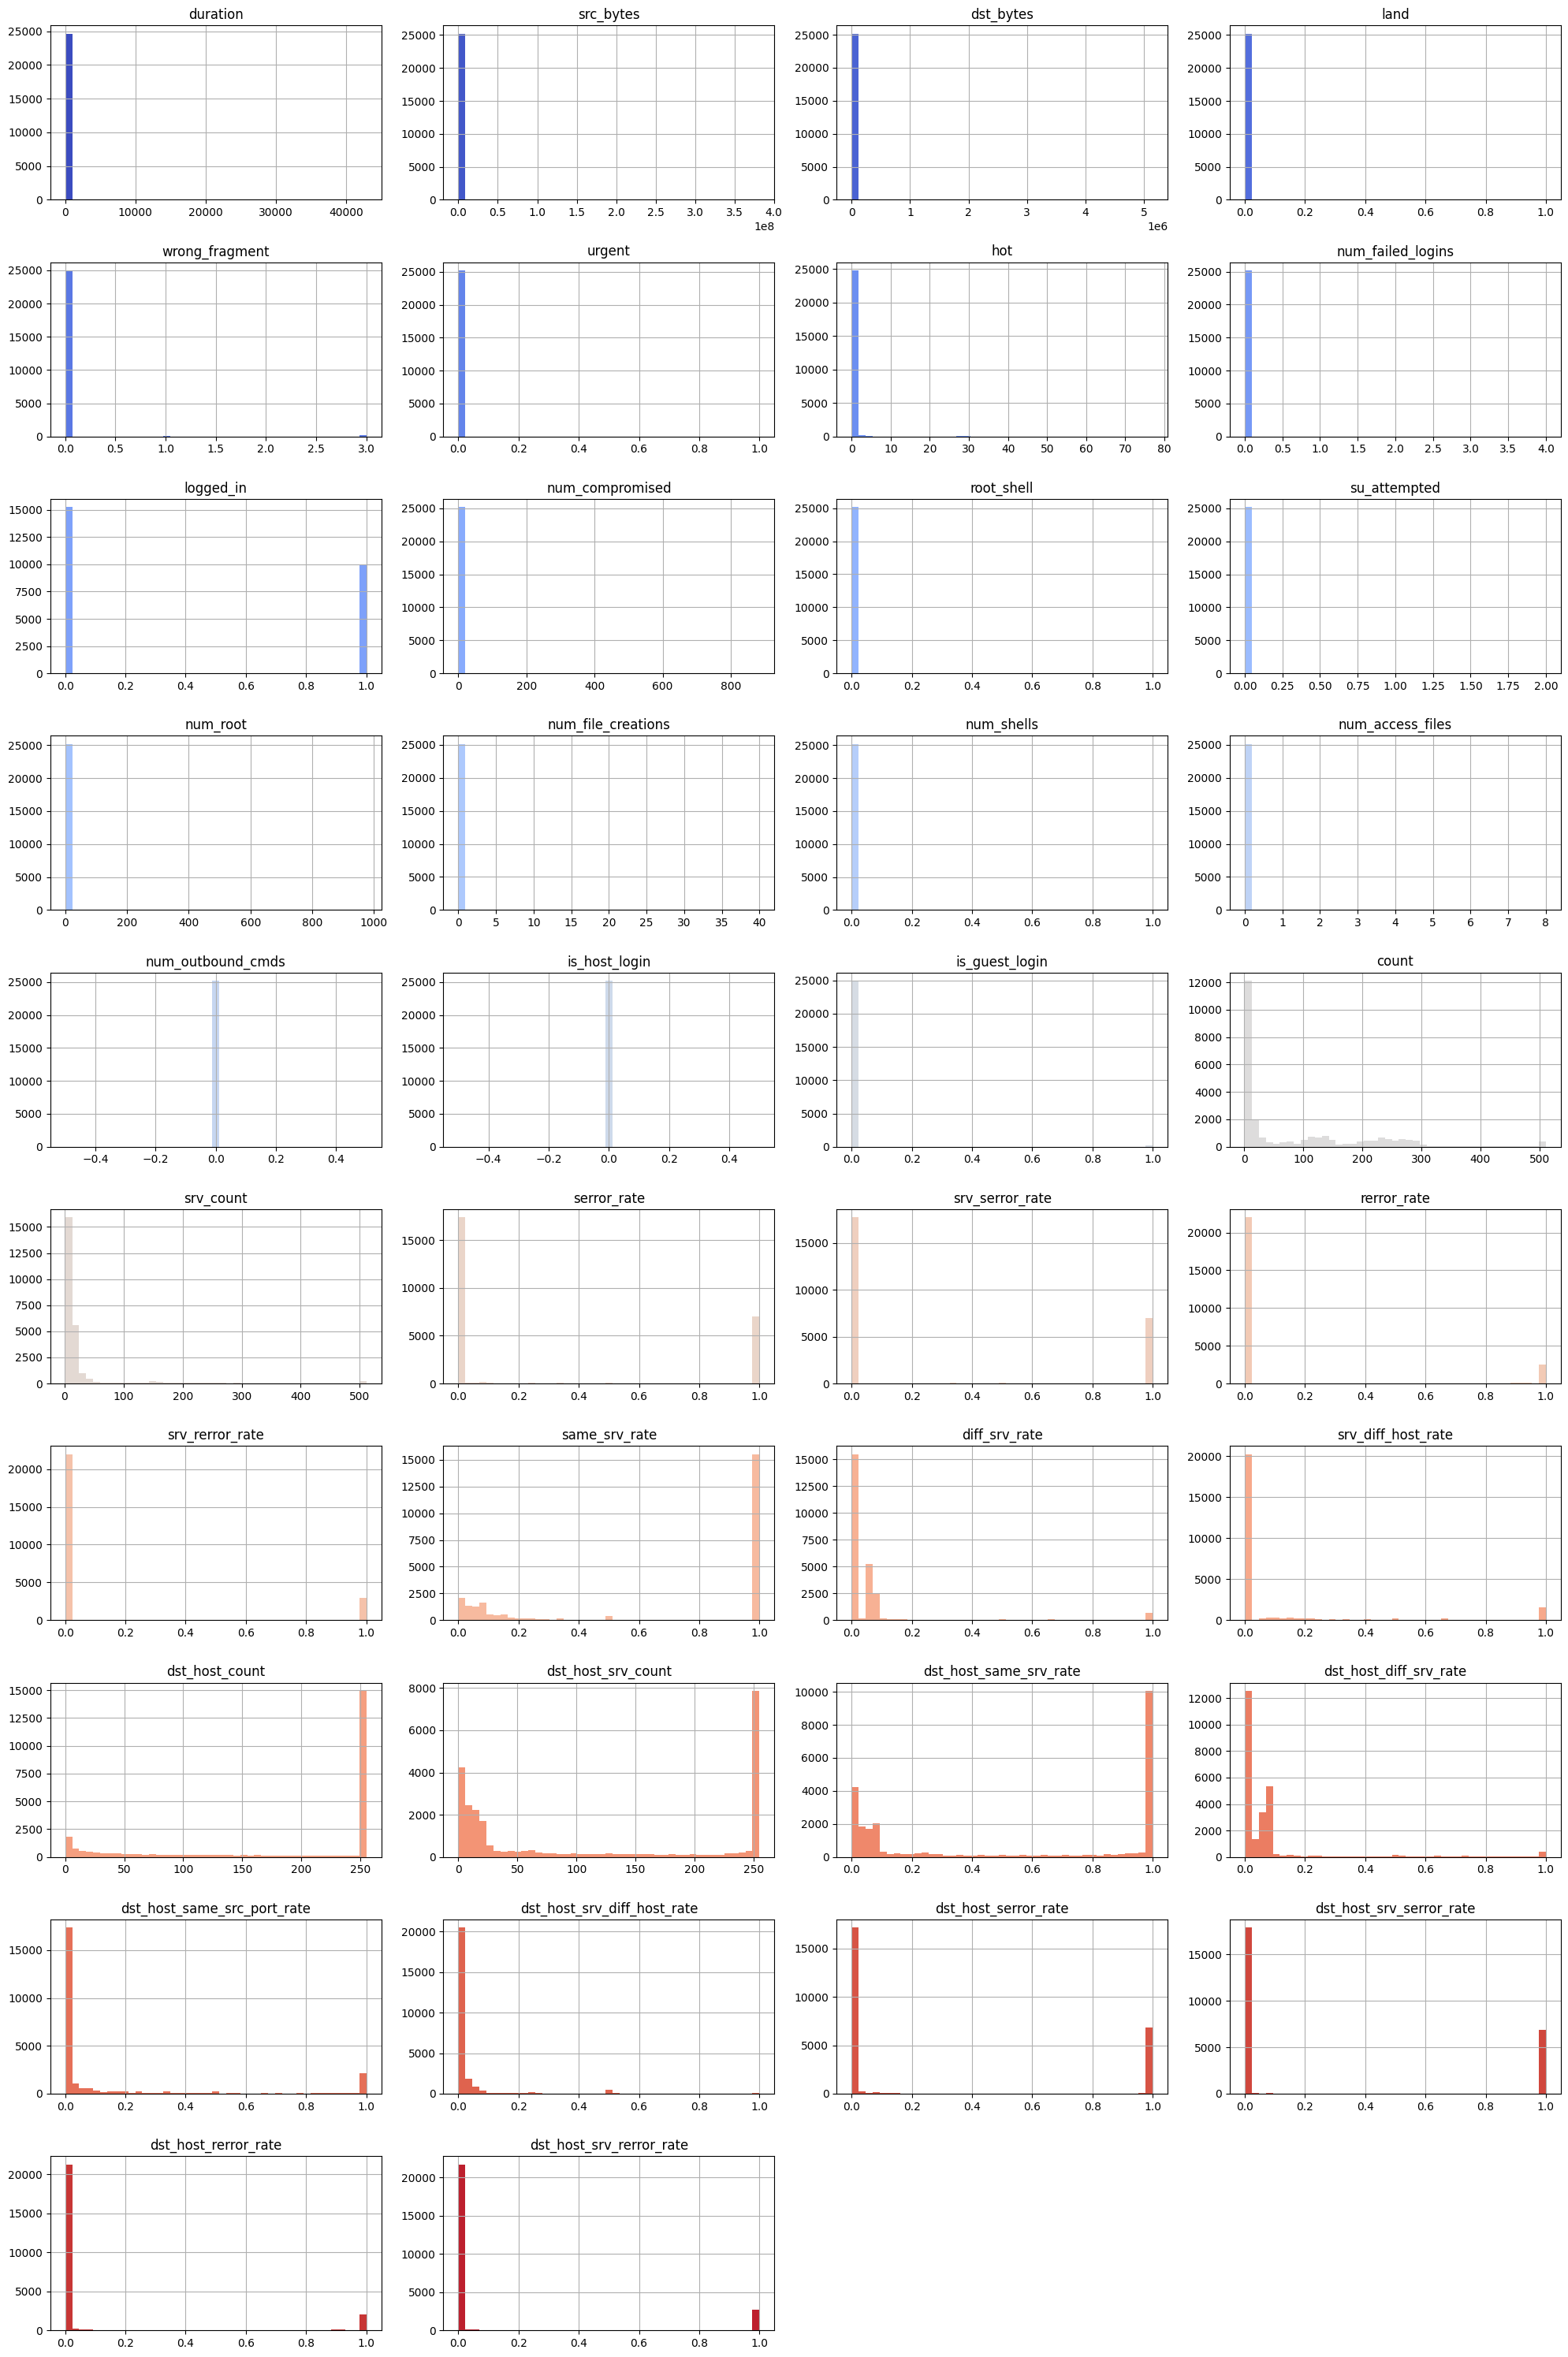

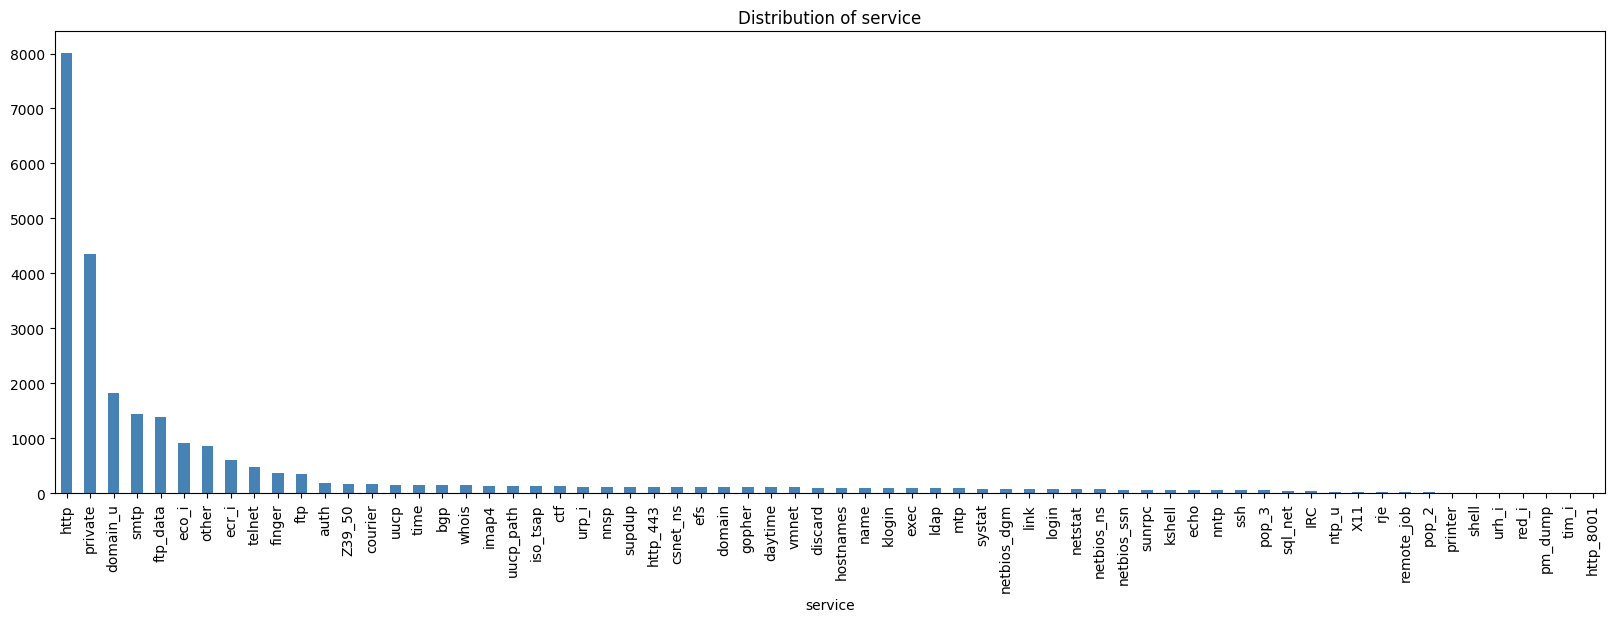

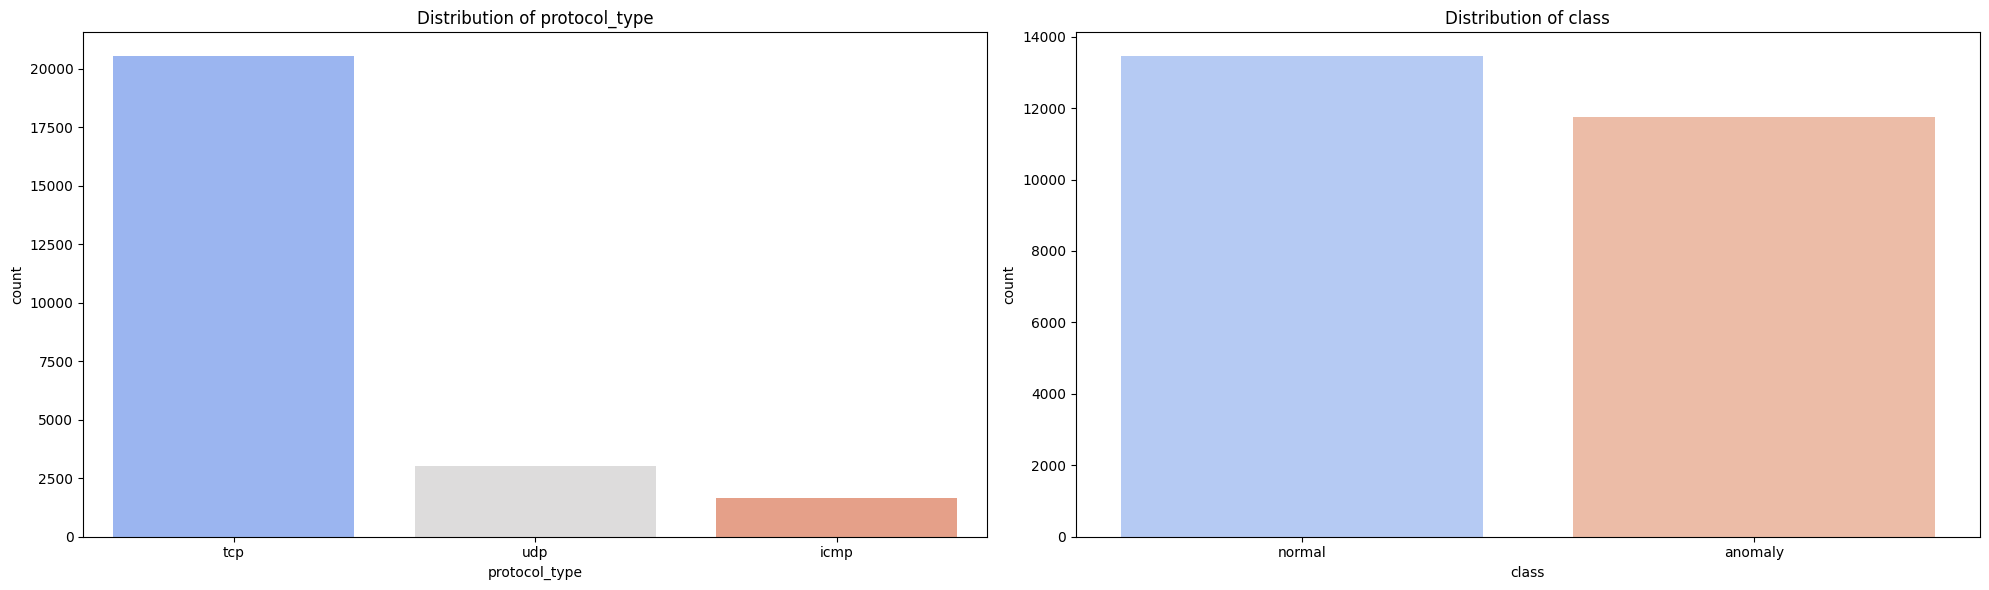

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Identify categorical columns
service_col = "service"
categorical_cols = ["protocol_type", "class"]

# Separate numerical columns
num_cols = train.select_dtypes(include=["number"]).columns

### PLOTTING NUMERICAL FEATURES ###
fig, axes = plt.subplots(len(num_cols) // 4 + 1, 4, figsize=(20, 30))
axes = axes.flatten()

# Plot histograms for numerical features
for i, column in enumerate(num_cols):
    train[column].hist(ax=axes[i], bins=43, color=plt.cm.coolwarm(i / len(num_cols)))
    axes[i].set_title(column)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### PLOTTING "SERVICE" ###
plt.figure(figsize=(20, 6))
train[service_col].value_counts().plot(kind="bar", color="steelblue")
plt.title(f"Distribution of {service_col}")
plt.xticks(rotation=90)
plt.show()

### PLOTTING "PROTOCOL_TYPE" & "CLASS" SIDE BY SIDE ###
fig, ax = plt.subplots(1, 2, figsize=(20, 6))  # 1 row, 2 columns

for i, cat_col in enumerate(categorical_cols):
    sns.countplot(x=train[cat_col], palette="coolwarm", ax=ax[i])
    ax[i].set_title(f"Distribution of {cat_col}")

plt.tight_layout()
plt.show()


# Data Preprocessing
* Missing Values
* Duplicates
* Label Encoding
* Correlation Matrix
* Features Selection
* Standard Scaler
* Dataset Splitting

**Missing Values**

In [15]:
train.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

**Duplicates**

In [16]:
print(f"Number of duplicates: {train.duplicated().sum()}")

Number of duplicates: 0


In [17]:
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


**Label Encoding**

In [18]:
label_encoder = LabelEncoder()
def le(df):
    for col in df.columns:
        if df[col].dtype == 'object':
                df[col] = label_encoder.fit_transform(df[col])

le(train)

In [19]:
train

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,1,19,9,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,1
1,0,2,41,9,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,1
2,0,1,46,5,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0
3,0,1,22,9,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,1
4,0,1,22,9,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25187,0,1,16,2,0,0,0,0,0,0,...,7,0.03,0.06,0.00,0.00,0.00,0.00,1.00,1.00,0
25188,0,1,19,9,334,0,0,0,0,0,...,39,1.00,0.00,1.00,0.18,0.00,0.00,0.00,0.00,0
25189,0,1,46,1,0,0,0,0,0,0,...,13,0.05,0.07,0.00,0.00,0.00,0.00,1.00,1.00,0
25190,0,1,38,5,0,0,0,0,0,0,...,20,0.08,0.06,0.00,0.00,1.00,1.00,0.00,0.00,0


**Correlation Matrix**

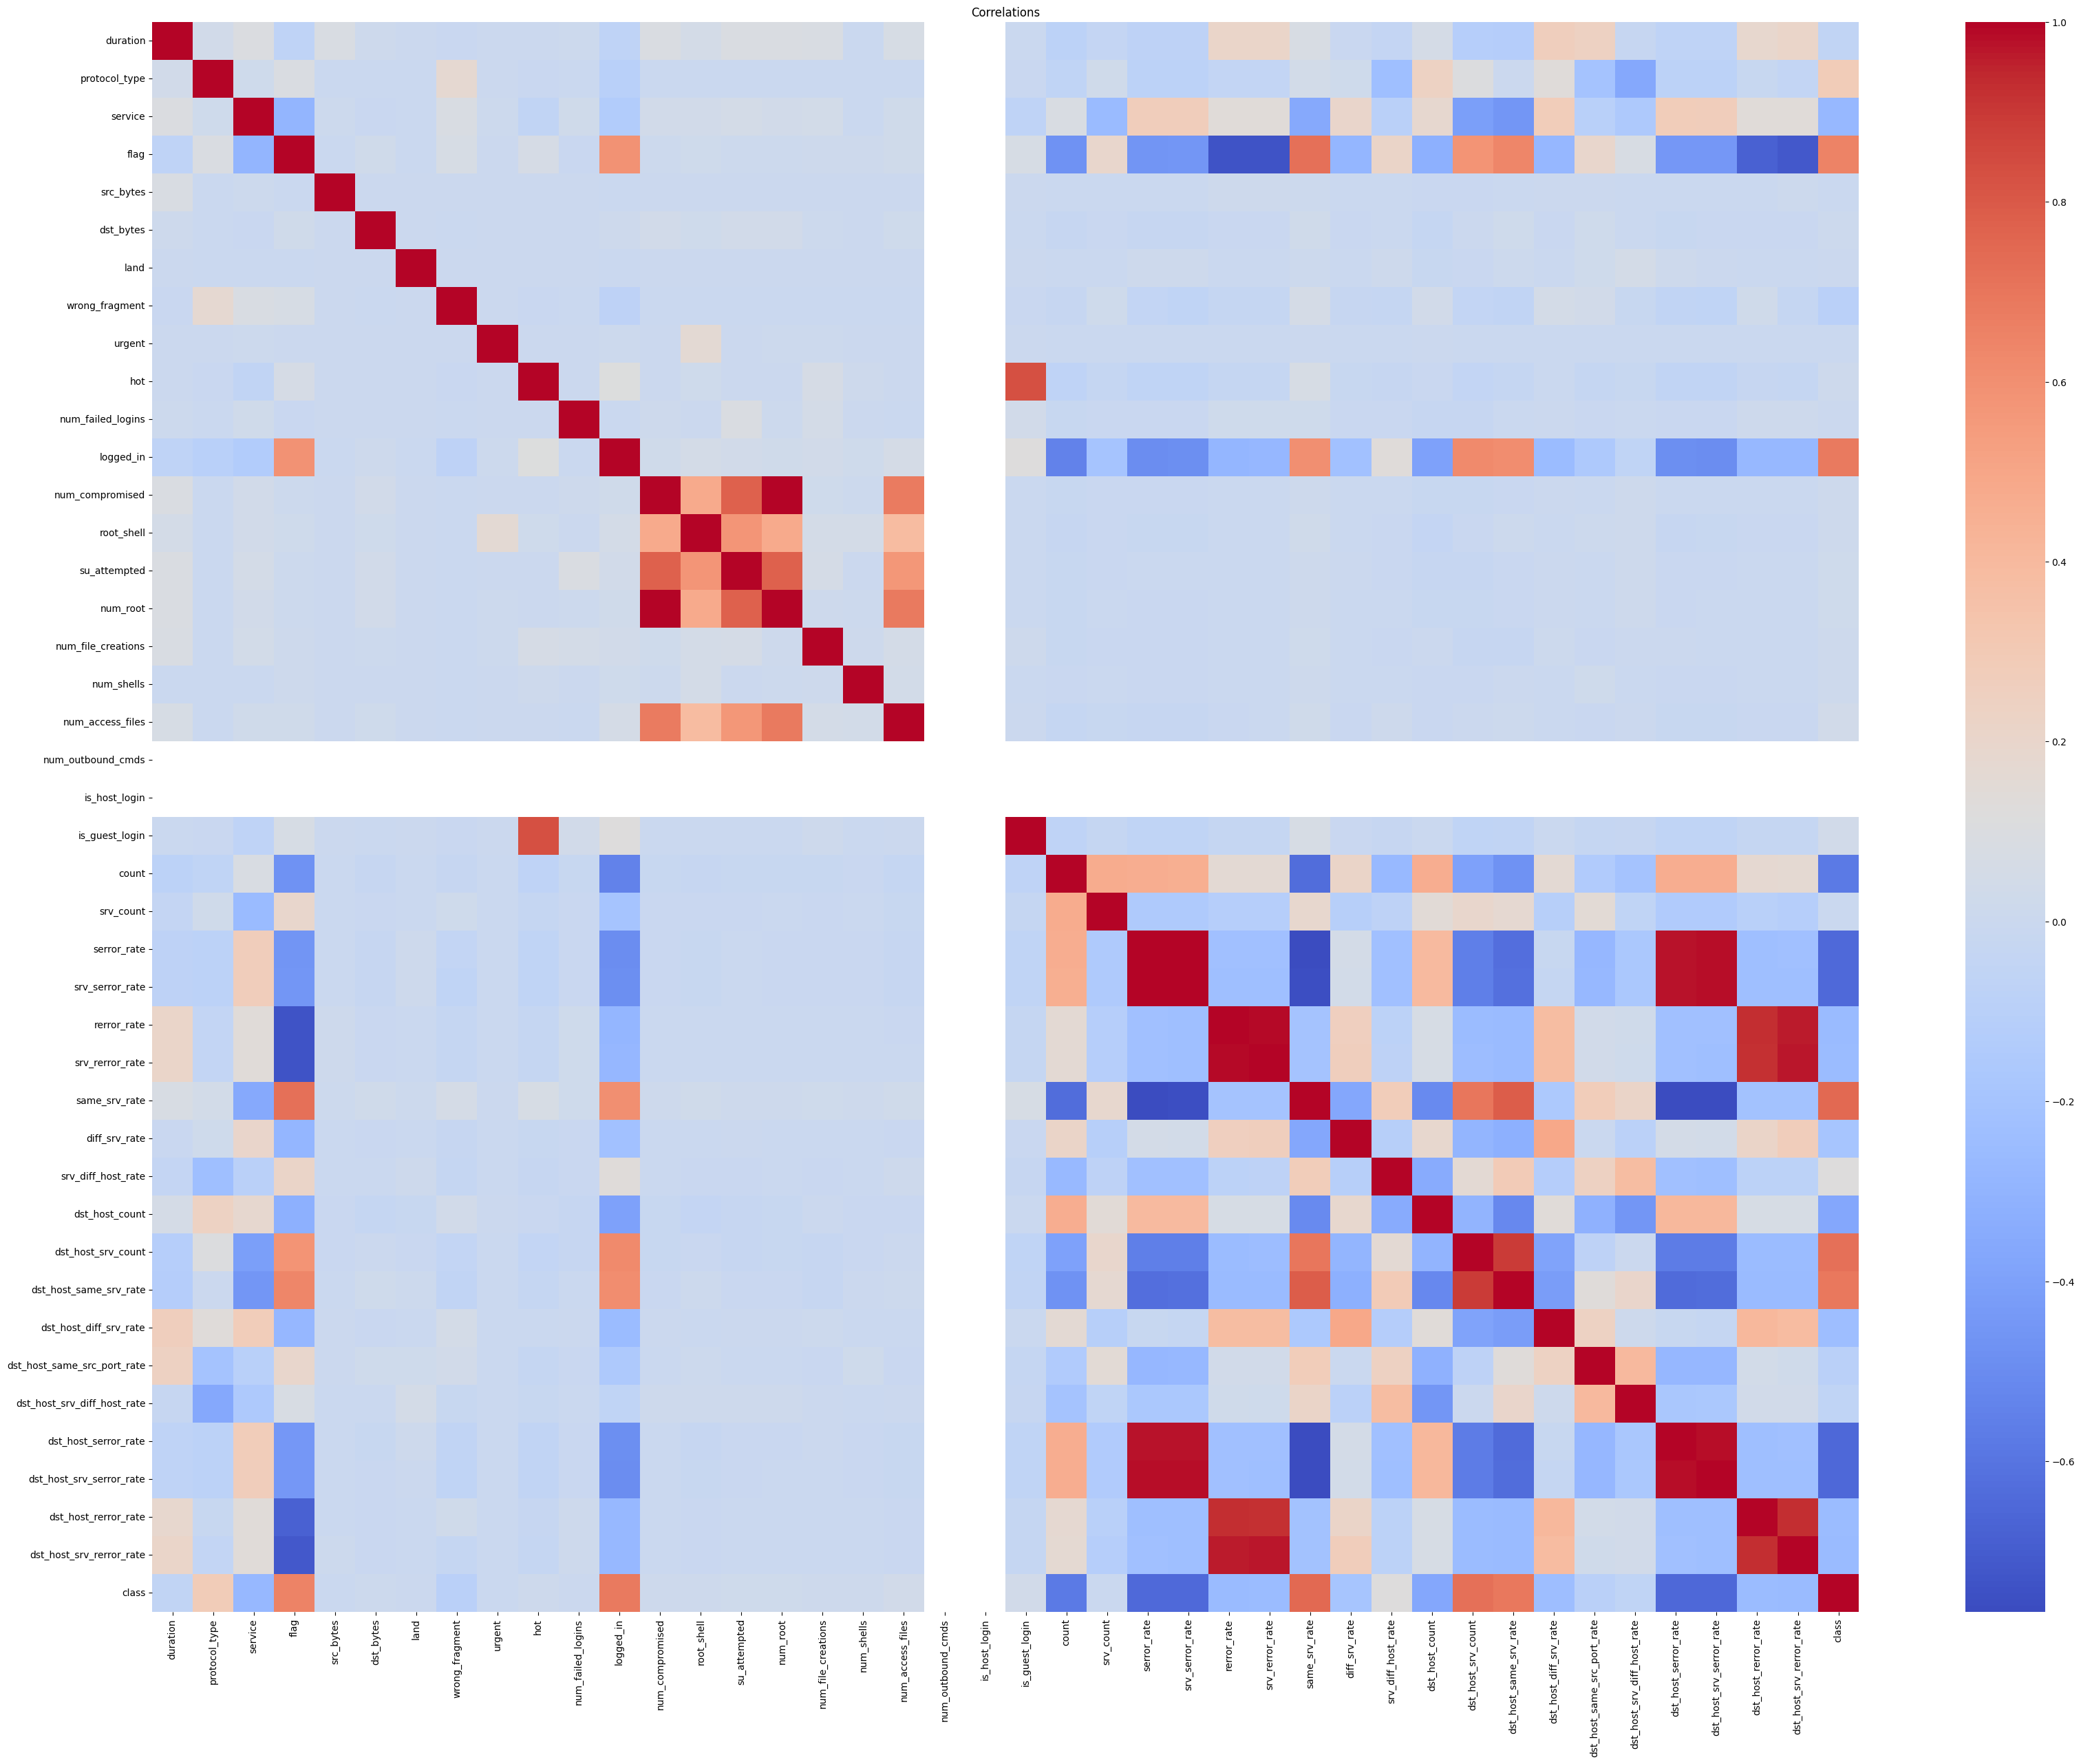

In [20]:
plt.figure(figsize=(40, 30))
#sns.heatmap(train.corr(), annot=True, fmt=".1f", cmap='coolwarm')
sns.heatmap(train.corr(numeric_only = True), fmt=".1f", cmap='coolwarm')
plt.title('Correlations')
plt.show()

Index(['flag', 'hot', 'num_compromised', 'su_attempted', 'num_root',
       'is_guest_login', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
       'srv_rerror_rate', 'same_srv_rate', 'dst_host_srv_count',
       'dst_host_same_srv_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class'],
      dtype='object')


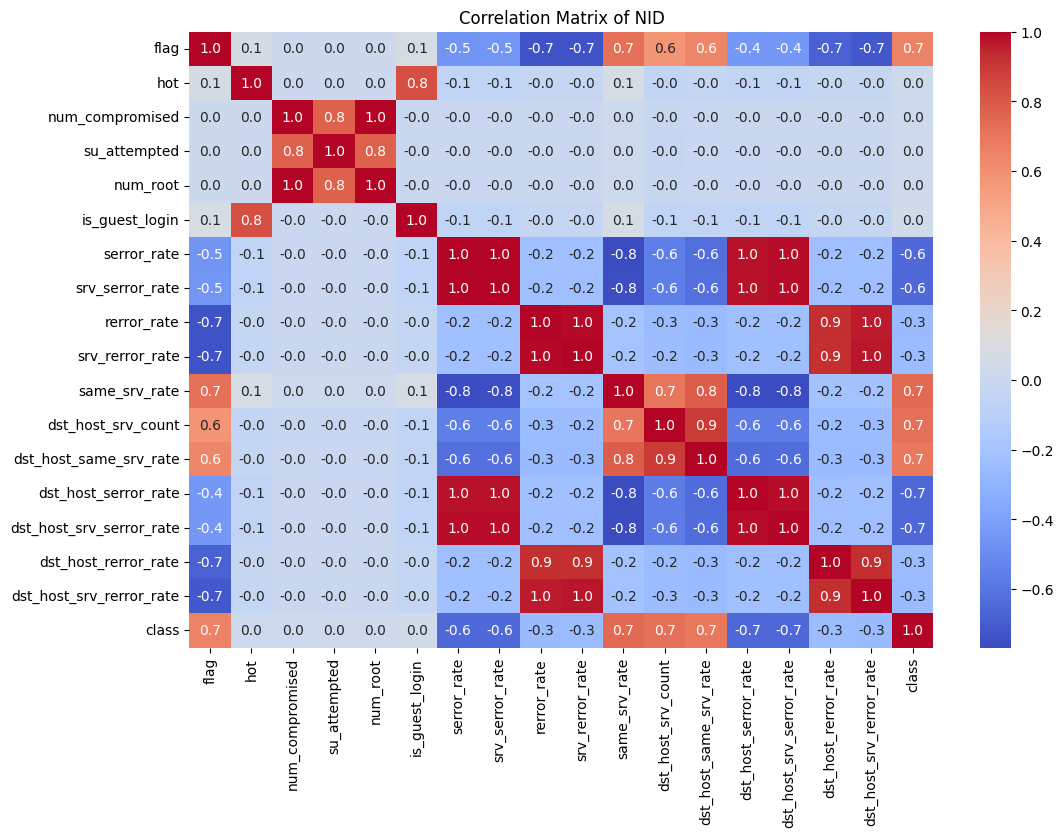

In [21]:
# only strong correlations
corr_matrix = train.corr()
threshold = 0.7

# Create a mask for values above the threshold or below the negative threshold, excluding self-correlation
mask = np.abs(corr_matrix) >= threshold
np.fill_diagonal(mask.values, False)

# Filter the columns and rows based on the mask
filtered_columns = corr_matrix.columns[mask.any()]
filtered_corr = corr_matrix.loc[filtered_columns, filtered_columns]

print(filtered_columns)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_corr, annot=True, fmt=".1f", cmap='coolwarm')
plt.title('Correlation Matrix of NID')
plt.show()

**Features Selection**

In [22]:
train['num_outbound_cmds']

0        0
1        0
2        0
3        0
4        0
        ..
25187    0
25188    0
25189    0
25190    0
25191    0
Name: num_outbound_cmds, Length: 25192, dtype: int64

In [23]:
#Drop the redundant feature
train.drop(['num_outbound_cmds'], axis=1, inplace=True)

In [24]:
X = train.drop(['class'], axis=1)
y = train['class']
rfc = RandomForestClassifier()

rfe = RFE(rfc, n_features_to_select=10)
rfe = rfe.fit(X, y)

feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), X.columns)]
selected_features = [v for i, v in feature_map if i==True]
top_features = pd.DataFrame({'Features': selected_features})
top_features.index = top_features.index + 1

In [ ]:
top_features

**Standard Scaler**

In [25]:
X = X[selected_features]
scale = StandardScaler()
X = scale.fit_transform(X)

**Dataset Splitting**

In [26]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.80,random_state=2)

# Model Selection
* Random Forest
* Logistic Regression
* Support Vector Machine (SVM)
* Decision Tree
* K-Nearest Neighbors (KNN)

**Random Forest**

============================== Random Forest Classifier ==============================
Accuracy:  0.9964278626711649
Precision:  0.9977777777777778
Random Forest Classification Report of NID:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      2333
           1       1.00      1.00      1.00      2706

    accuracy                           1.00      5039
   macro avg       1.00      1.00      1.00      5039
weighted avg       1.00      1.00      1.00      5039



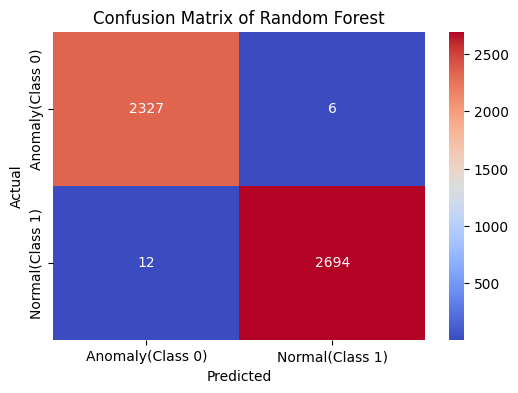


Confusion Matrix Parameters for Random Forest):
True Negatives (TN): 2327
False Positives (FP): 6
False Negatives (FN): 12
True Positives (TP): 2694


In [27]:
print('============================== Random Forest Classifier ==============================')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
rfc.fit(X_train,y_train)
rfc_pred = rfc.predict(X_test)
report = classification_report(y_test, rfc_pred)
cm = confusion_matrix(y_test, rfc_pred)

print("Accuracy: ", accuracy_score(y_test,rfc_pred))
print("Precision: ", precision_score(y_test,rfc_pred))
print("Random Forest Classification Report of NID:\n", report)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Anomaly(Class 0)","Normal(Class 1)"], yticklabels=["Anomaly(Class 0)","Normal(Class 1)"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix of Random Forest")
plt.show()

tn, fp, fn, tp = confusion_matrix(y_test, rfc_pred).ravel()
print('\nConfusion Matrix Parameters for Random Forest):')
print("True Negatives (TN):",tn)
print("False Positives (FP):",fp)
print("False Negatives (FN):",fn)
print("True Positives (TP):",tp)

**Logistic Regression**

============================== Logistic Regression ==============================
Accuracy:  0.9196269101012106
Precision:  0.9069685178634594
Logistic Regression Classification Report of NID:
               precision    recall  f1-score   support

           0       0.94      0.89      0.91      2333
           1       0.91      0.95      0.93      2706

    accuracy                           0.92      5039
   macro avg       0.92      0.92      0.92      5039
weighted avg       0.92      0.92      0.92      5039



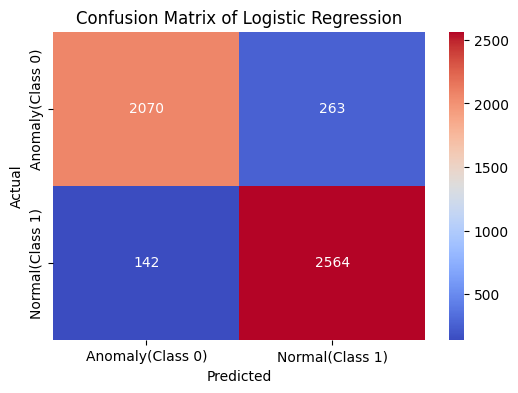


Confusion Matrix Parameters for Logistic Regression):
True Negatives (TN): 2070
False Positives (FP): 263
False Negatives (FN): 142
True Positives (TP): 2564


In [28]:
print('============================== Logistic Regression ==============================')
lrc = LogisticRegression()
lrc.fit(X_train,y_train)
lrc_pred = lrc.predict(X_test)
report = classification_report(y_test, lrc_pred)
cm = confusion_matrix(y_test, lrc_pred)

print("Accuracy: ", accuracy_score(y_test,lrc_pred))
print("Precision: ", precision_score(y_test,lrc_pred))
print("Logistic Regression Classification Report of NID:\n", report)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Anomaly(Class 0)","Normal(Class 1)"], yticklabels=["Anomaly(Class 0)","Normal(Class 1)"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix of Logistic Regression")
plt.show()

tn, fp, fn, tp = confusion_matrix(y_test, lrc_pred).ravel()
print('\nConfusion Matrix Parameters for Logistic Regression):')
print("True Negatives (TN):",tn)
print("False Positives (FP):",fp)
print("False Negatives (FN):",fn)
print("True Positives (TP):",tp)

**Decision Tree**

============================== Decision-Tree Classifier ==============================
Accuracy:  0.9960309585235165
Precision:  0.9985152190051967
Decision-Tree Classification Report of NID:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      2333
           1       1.00      0.99      1.00      2706

    accuracy                           1.00      5039
   macro avg       1.00      1.00      1.00      5039
weighted avg       1.00      1.00      1.00      5039



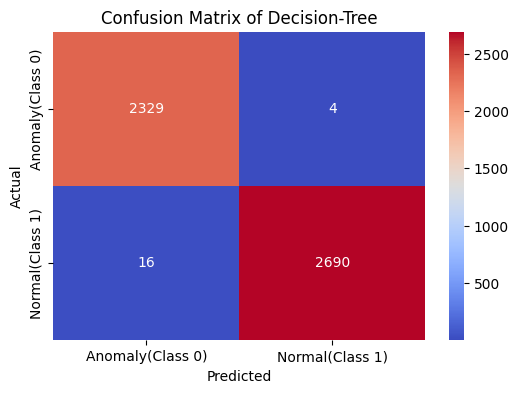


Confusion Matrix Parameters for Decision-Tree:
True Negatives (TN): 2329
False Positives (FP): 4
False Negatives (FN): 16
True Positives (TP): 2690


In [29]:
print('============================== Decision-Tree Classifier ==============================')
dtc = DecisionTreeClassifier(max_depth=15,criterion='entropy')
dtc.fit(X_train,y_train)
dtc_pred = dtc.predict(X_test)
report = classification_report(y_test, dtc_pred)
cm = confusion_matrix(y_test, dtc_pred)

print("Accuracy: ", accuracy_score(y_test,dtc_pred))
print("Precision: ", precision_score(y_test,dtc_pred))
print("Decision-Tree Classification Report of NID:\n", report)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Anomaly(Class 0)","Normal(Class 1)"], yticklabels=["Anomaly(Class 0)","Normal(Class 1)"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix of Decision-Tree")
plt.show()

tn, fp, fn, tp = confusion_matrix(y_test, dtc_pred).ravel()
print('\nConfusion Matrix Parameters for Decision-Tree:')
print("True Negatives (TN):",tn)
print("False Positives (FP):",fp)
print("False Negatives (FN):",fn)
print("True Positives (TP):",tp)

In [30]:
# Decision Tree Visualization
from sklearn.tree import plot_tree
from sklearn import tree

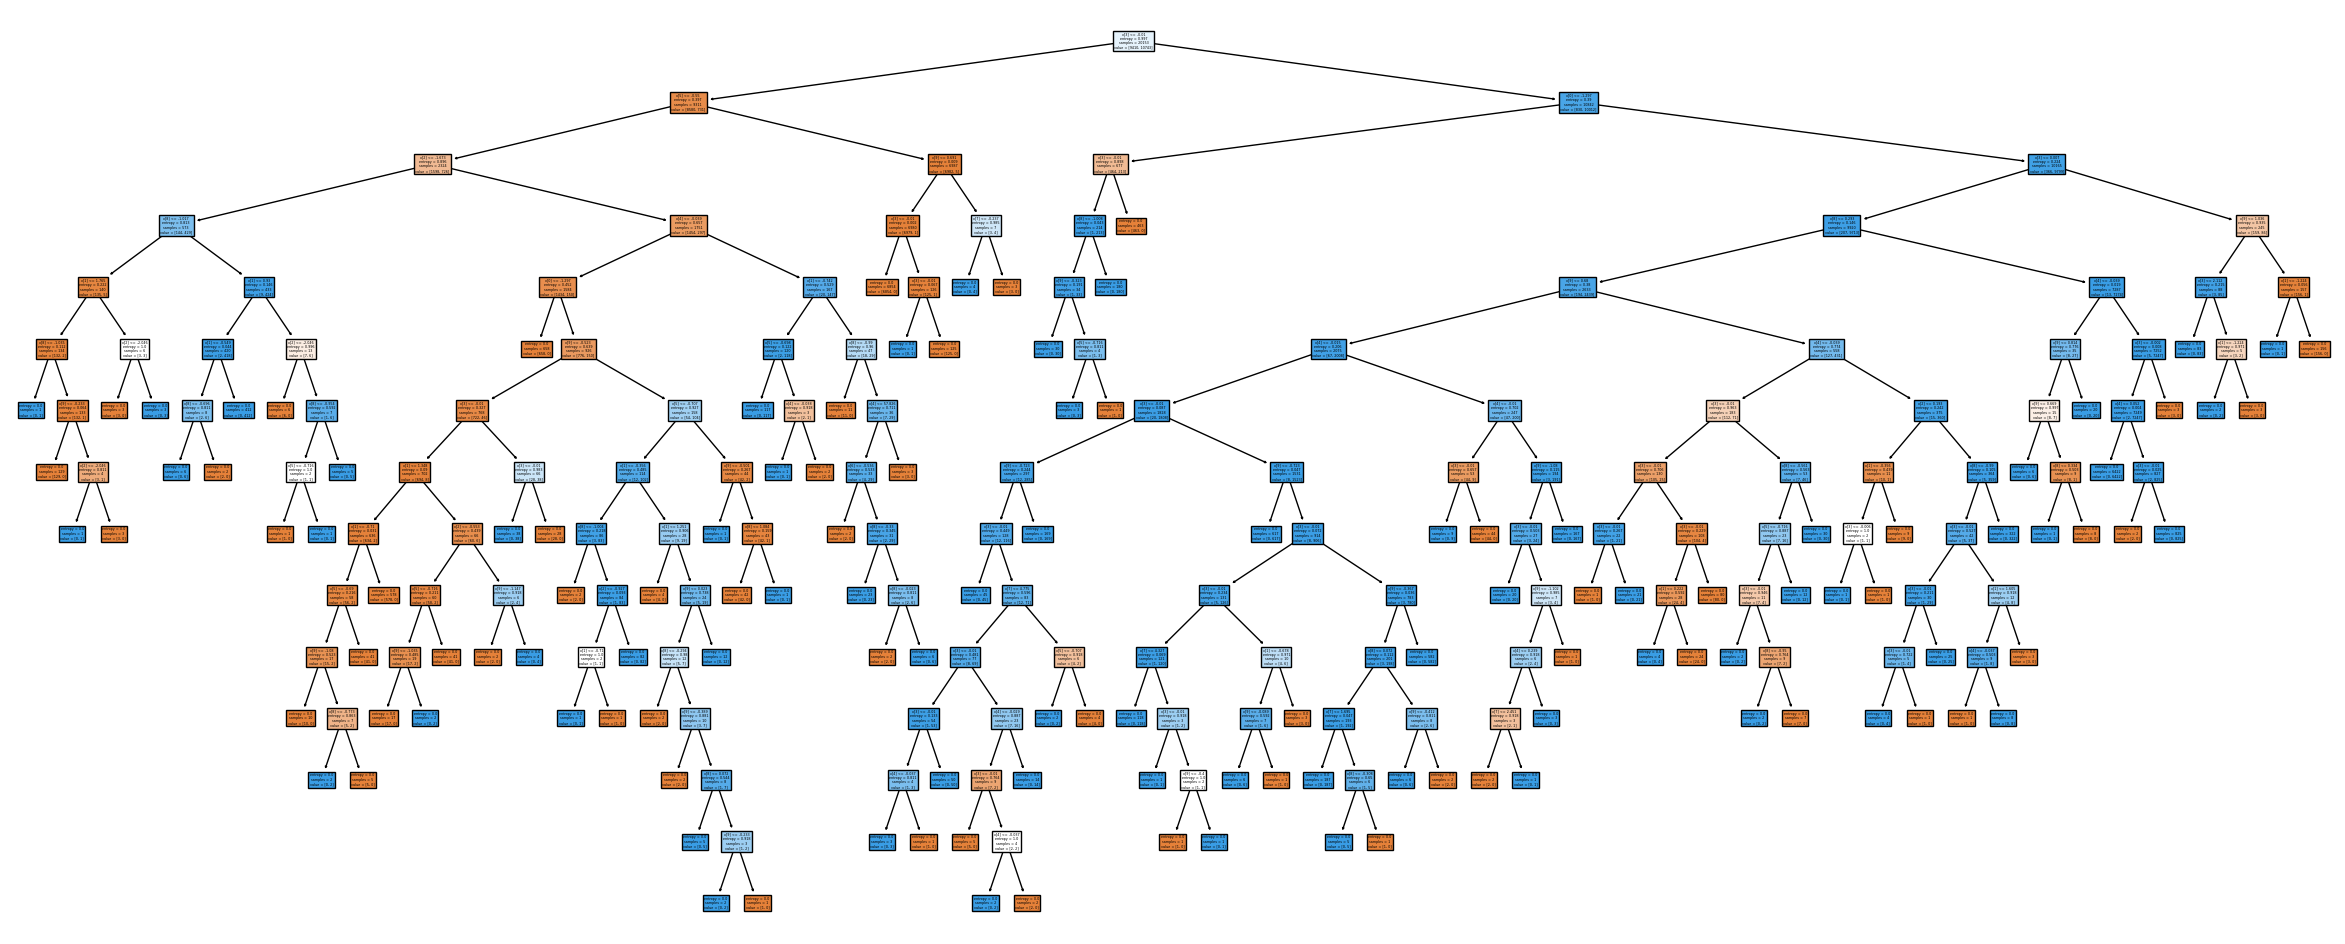

In [31]:
fig = plt.figure(figsize = (30,12))
tree.plot_tree(dtc, filled=True);
plt.show()

**K-Nearest Neighbors (KNN)**

============================== K-Neighbors Classifier ==============================
Accuracy:  0.9833300257987696
Precision:  0.9844789356984479
KNN Classification Report of NID:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      2333
           1       0.98      0.98      0.98      2706

    accuracy                           0.98      5039
   macro avg       0.98      0.98      0.98      5039
weighted avg       0.98      0.98      0.98      5039



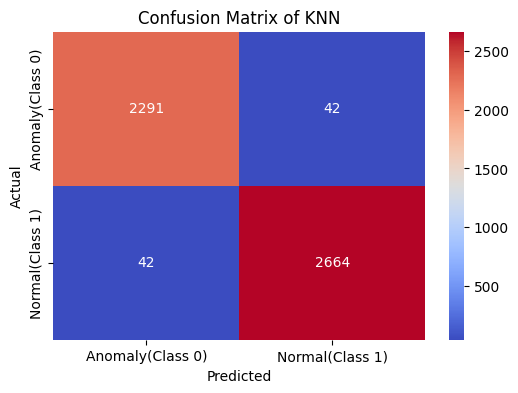


Confusion Matrix Parameters for K-Nearest Neighbors (KNN):
True Negatives (TN): 2291
False Positives (FP): 42
False Negatives (FN): 42
True Positives (TP): 2664


In [32]:
print('============================== K-Neighbors Classifier ==============================')
knc = KNeighborsClassifier()
knc.fit(X_train,y_train)
knc_pred = knc.predict(X_test)
report = classification_report(y_test, knc_pred)
cm = confusion_matrix(y_test, knc_pred)

print("Accuracy: ", accuracy_score(y_test,knc_pred))
print("Precision: ", precision_score(y_test,knc_pred))
print("KNN Classification Report of NID:\n", report)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Anomaly(Class 0)","Normal(Class 1)"], yticklabels=["Anomaly(Class 0)","Normal(Class 1)"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix of KNN")
plt.show()

tn, fp, fn, tp = confusion_matrix(y_test, knc_pred).ravel()
print('\nConfusion Matrix Parameters for K-Nearest Neighbors (KNN):')
print("True Negatives (TN):",tn)
print("False Positives (FP):",fp)
print("False Negatives (FN):",fn)
print("True Positives (TP):",tp)

**Support Vector Machine (SVM)**

=============================== Support Vector Machine ==============================
Accuracy:  0.9769795594363961
Precision:  0.9712518195050946
SVM Classification Report of NID:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97      2333
           1       0.97      0.99      0.98      2706

    accuracy                           0.98      5039
   macro avg       0.98      0.98      0.98      5039
weighted avg       0.98      0.98      0.98      5039



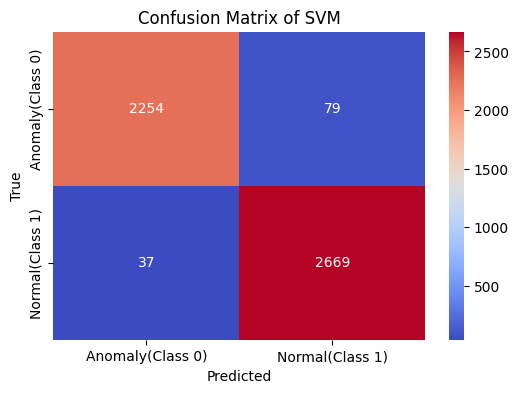


Confusion Matrix Parameters for Support Vector Machine (SVM):
True Negatives (TN): 2254
False Positives (FP): 79
False Negatives (FN): 37
True Positives (TP): 2669


In [33]:
print('=============================== Support Vector Machine ==============================')
svm = SVC(kernel='poly', gamma=1.0)
svm.fit(X_train,y_train)
svm_pred = svm.predict(X_test)
report = classification_report(y_test, svm_pred)
cm = confusion_matrix(y_test, svm_pred)

print("Accuracy: ", accuracy_score(y_test,svm_pred))
print("Precision: ", precision_score(y_test,svm_pred))
print("SVM Classification Report of NID:\n", report)
plt.figure(figsize=(6, 4))
#sns.heatmap(cm, annot=True, cmap='Reds', fmt='g')
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Anomaly(Class 0)","Normal(Class 1)"], yticklabels=["Anomaly(Class 0)","Normal(Class 1)"])
#sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix of SVM")
plt.show()

tn, fp, fn, tp = confusion_matrix(y_test, svm_pred).ravel()
print('\nConfusion Matrix Parameters for Support Vector Machine (SVM):')
print("True Negatives (TN):",tn)
print("False Positives (FP):",fp)
print("False Negatives (FN):",fn)
print("True Positives (TP):",tp)

# Receiver Operating Characteristic (ROC) Curve for Intrusion Detection

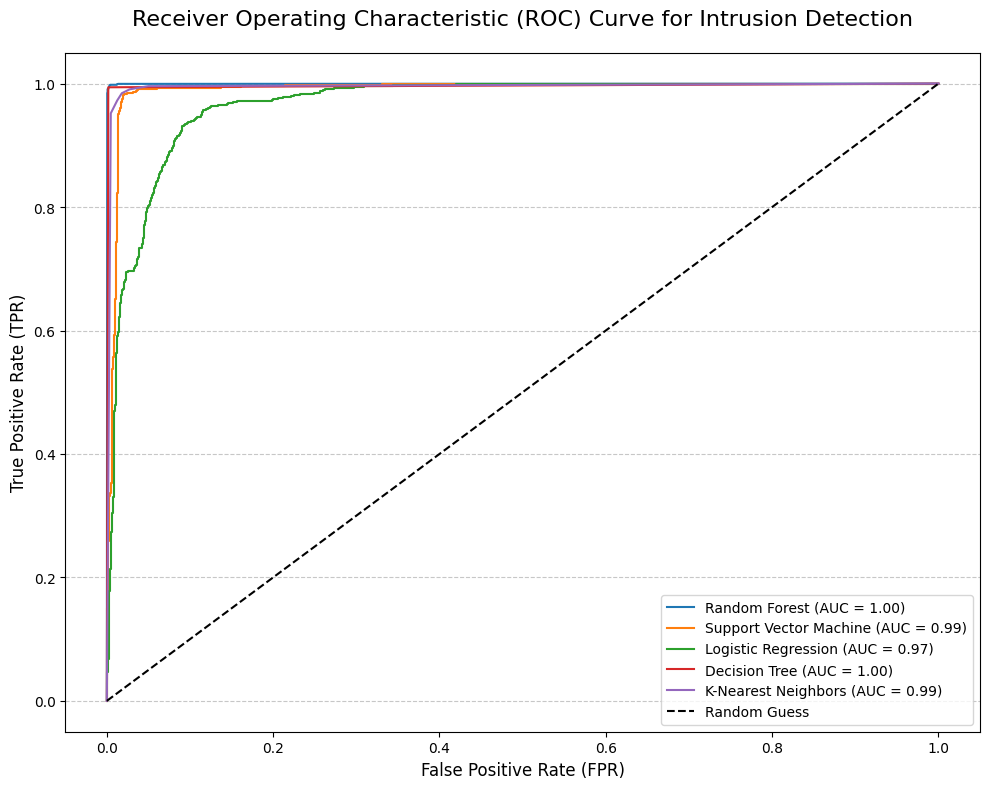

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels (if not already binary)
y_test_bin = label_binarize(y_test, classes=[0, 1])
n_classes = y_test_bin.shape[1]

# Initialize a figure
plt.figure(figsize=(10, 8))

# Define models and their predictions
models = {
    'Random Forest': rfc,
    'Support Vector Machine': svm,
    'Logistic Regression': lrc,
    'Decision Tree': dtc,
    'K-Nearest Neighbors': knc
}

# Plot ROC curve for each model
for model_name, model in models.items():
    if hasattr(model, 'predict_proba'):
        y_score = model.predict_proba(X_test)[:, 1]  # Probability of positive class
    elif hasattr(model, 'decision_function'):
        y_score = model.decision_function(X_test)  # Decision function scores
    else:
        y_score = model.predict(X_test)  

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test_bin, y_score)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random Guess')

# Formatting
plt.title('Receiver Operating Characteristic (ROC) Curve for Intrusion Detection', fontsize=16, pad=20)
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.legend(loc='lower right', fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

# Training and Validation Accuracy

In [35]:
from tensorflow.keras import Sequential


In [36]:
from tensorflow.keras.layers import Dense, Dropout

In [37]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [38]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [39]:
history = model.fit(X_train,y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8998 - loss: 0.2750 - val_accuracy: 0.9625 - val_loss: 0.1131
Epoch 2/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9529 - loss: 0.1312 - val_accuracy: 0.9665 - val_loss: 0.1027
Epoch 3/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9589 - loss: 0.1137 - val_accuracy: 0.9635 - val_loss: 0.0982
Epoch 4/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9642 - loss: 0.1054 - val_accuracy: 0.9668 - val_loss: 0.0961
Epoch 5/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9647 - loss: 0.1077 - val_accuracy: 0.9668 - val_loss: 0.0949
Epoch 6/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9649 - loss: 0.1068 - val_accuracy: 0.9663 - val_loss: 0.0908
Epoch 7/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9620 - loss: 0.1064 - val_accuracy: 0.9665 - val_loss: 0.0899
Epoch 8/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9687 - loss: 0.0905 - val_accuracy: 0.

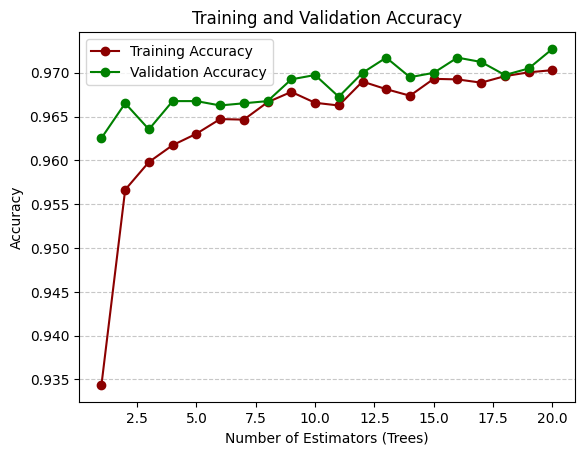

In [40]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
epochs = range(1, len(training_accuracy) + 1)

# Plot Training and Validation Accuracy
#plt.figure(figsize=(10, 6))
plt.plot(epochs, training_accuracy, 'darkred', label='Training Accuracy', marker='o')
plt.plot(epochs, validation_accuracy, 'green',label='Validation Accuracy', marker='o')
plt.xlabel('Number of Estimators (Trees)')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.show()

In [41]:
test_loss, test_acc = model.evaluate(X_test,y_test)
print(f'Test accuracy: {test_acc}')

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9668 - loss: 0.0875
Test accuracy: 0.9688430428504944


In [42]:
predictions = model.predict(X_test)
predictions = (predictions > 0.5)

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [43]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,453 (33.02 KB)

 Trainable params: 2,817 (11.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,636 (22.02 KB)

In [44]:
y_pred = (predictions > 0.5).astype(int)

In [45]:
report = classification_report(y_test, y_pred)

In [46]:
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2333
           1       0.97      0.97      0.97      2706

    accuracy                           0.97      5039
   macro avg       0.97      0.97      0.97      5039
weighted avg       0.97      0.97      0.97      5039



# Visualization of Anomaly Score Distributions

Use a histogram or Kernel Density Estimate (KDE) plot to visualize the distribution of anomaly scores for Normal and Attack/Anomaly classes.

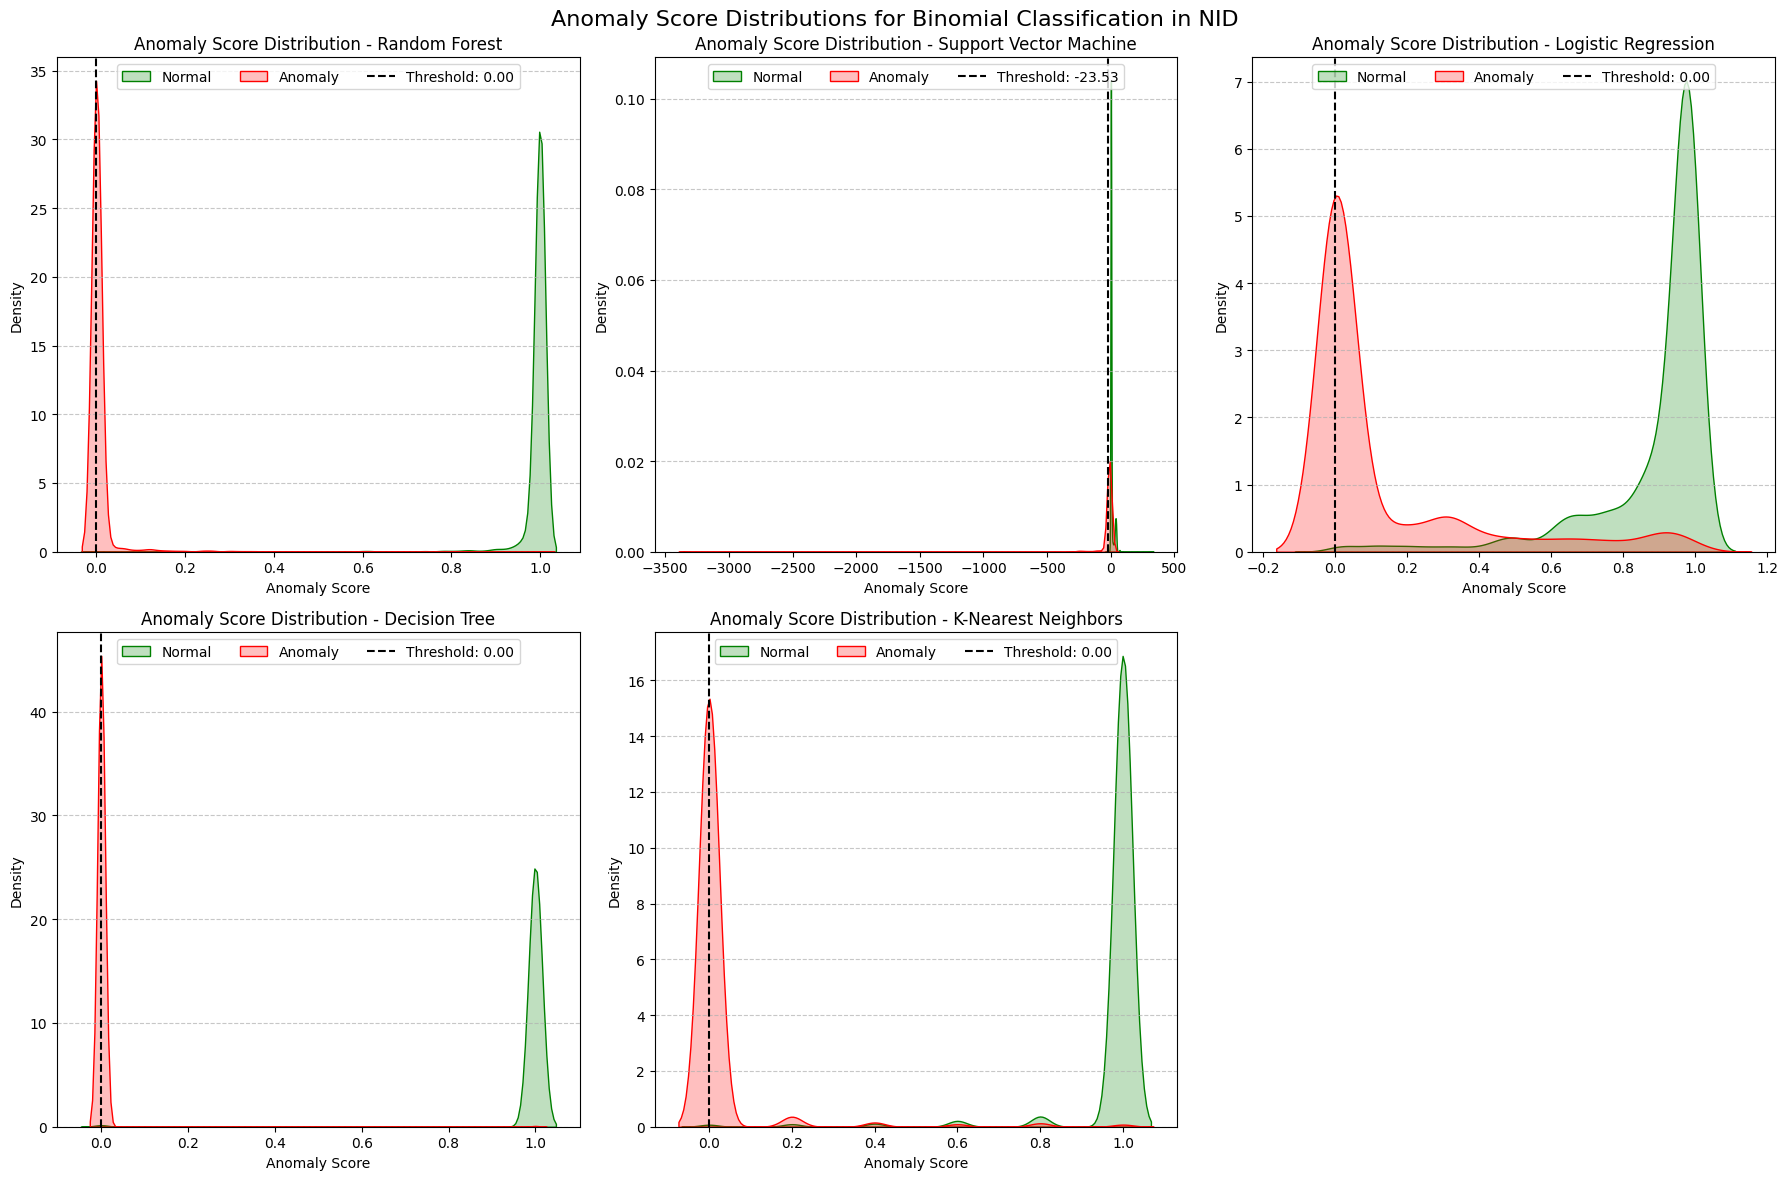

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to plot anomaly score distribution with threshold line
def plot_anomaly_score_distribution(ax, y_true, anomaly_scores, model_name):
    # Plot density for normal and attack classes
    sns.kdeplot(anomaly_scores[y_true == 1], label='Normal', color='green', fill=True, ax=ax)
    sns.kdeplot(anomaly_scores[y_true == 0], label='Anomaly', color='red', fill=True, ax=ax)
    
    # Calculate threshold (e.g., 5th percentile of anomaly scores)
    threshold = np.percentile(anomaly_scores, 5)  # Adjust percentile as needed
    ax.axvline(threshold, color='black', linestyle='--', label=f'Threshold: {threshold:.2f}')
    
    # Formatting
    ax.set_title(f'Anomaly Score Distribution - {model_name}', fontsize=12)
    ax.set_xlabel('Anomaly Score', fontsize=10)
    ax.set_ylabel('Density', fontsize=10)
    ax.legend(loc="upper center", ncol=5, fontsize=10)
    
    # Add grid lines
    ax.grid(axis='y', linestyle='--', alpha=0.7)  # Horizontal grid lines

# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # 2 rows, 3 columns
fig.suptitle('Anomaly Score Distributions for Binomial Classification in NID', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Calculate and plot anomaly scores for each model

# Random Forest
rf_scores = rfc.predict_proba(X_test)[:, 1]  # Probability of being an attack
plot_anomaly_score_distribution(axes[0], y_test, rf_scores, 'Random Forest')

# SVM
svm_scores = svm.decision_function(X_test)  # Decision function scores
plot_anomaly_score_distribution(axes[1], y_test, svm_scores, 'Support Vector Machine')

# Logistic Regression
lr_scores = lrc.predict_proba(X_test)[:, 1]  # Probability of being an attack
plot_anomaly_score_distribution(axes[2], y_test, lr_scores, 'Logistic Regression')

# Decision Tree
dt_scores = dtc.predict_proba(X_test)[:, 1]  # Probability of being an attack
plot_anomaly_score_distribution(axes[3], y_test, dt_scores, 'Decision Tree')

# KNN
knn_scores = knc.predict_proba(X_test)[:, 1]  # Probability of being an attack
plot_anomaly_score_distribution(axes[4], y_test, knn_scores, 'K-Nearest Neighbors')

# Hide the empty subplot (if any)
axes[5].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

# Check unique values in the target variable
unique_classes = np.unique(y)
print("Unique Classes in Target Variable:", unique_classes)

In [48]:
from collections import Counter

# Count the number of instances for each class
class_distribution = Counter(y)
print("Class Distribution:", class_distribution)

Class Distribution: Counter({1: 13449, 0: 11743})


It confirms that this dataset is for Binomial Classification (Binary Classification) for Intrusion Detection Systems (IDSs). The goal is to classify network traffic as Normal or Attack/Anomaly, a classic binary classification problem.

# Model Summary
* Confusion Matrix Parameters
* Model Performance Comparison for Intrusion Detection
* Accuracy of Different ML Models

Confusion Matrix Parameters for All Models:
                    Model  True Negatives (TN)  False Positives (FP)  \
0           Random Forest                 2327                     6   
1  Support Vector Machine                 2254                    79   
2     Logistic Regression                 2070                   263   
3           Decision Tree                 2329                     4   
4     K-Nearest Neighbors                 2291                    42   

   False Negatives (FN)  True Positives (TP)  
0                    12                 2694  
1                    37                 2669  
2                   142                 2564  
3                    16                 2690  
4                    42                 2664  


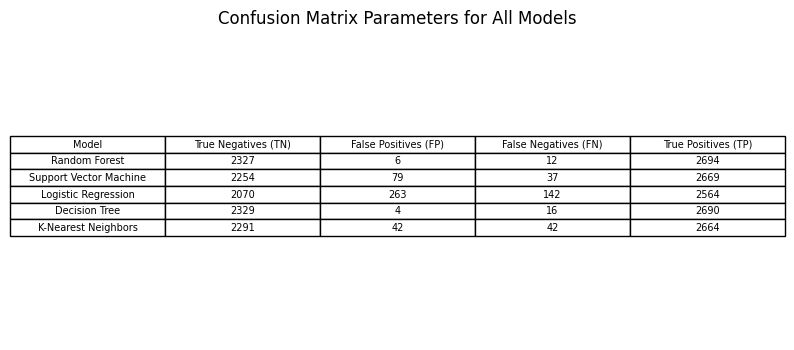

In [49]:
import pandas as pd
from sklearn.metrics import confusion_matrix

# Function to extract confusion matrix parameters
def get_confusion_matrix_params(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn, fp, fn, tp

# Initialize a dictionary to store confusion matrix parameters
confusion_matrix_data = {
    'Model': [],
    'True Negatives (TN)': [],
    'False Positives (FP)': [],
    'False Negatives (FN)': [],
    'True Positives (TP)': []
}

# Evaluate each model
models = {
    'Random Forest': rfc_pred,
    'Support Vector Machine': svm_pred,
    'Logistic Regression': lrc_pred,
    'Decision Tree': dtc_pred,
    'K-Nearest Neighbors': knc_pred
}

for model_name, y_pred in models.items():
    tn, fp, fn, tp = get_confusion_matrix_params(y_test, y_pred)
    confusion_matrix_data['Model'].append(model_name)
    confusion_matrix_data['True Negatives (TN)'].append(tn)
    confusion_matrix_data['False Positives (FP)'].append(fp)
    confusion_matrix_data['False Negatives (FN)'].append(fn)
    confusion_matrix_data['True Positives (TP)'].append(tp)

# Create a DataFrame
confusion_matrix_df = pd.DataFrame(confusion_matrix_data)

# Display the table
print("Confusion Matrix Parameters for All Models:")
print(confusion_matrix_df)

# Optionally, save the table to a CSV file
#confusion_matrix_df.to_csv('confusion_matrix_parameters.csv', index=False)

# Plot the table
plt.figure(figsize=(10, 4))
plt.axis('off')  # Hide axes
plt.table(cellText=confusion_matrix_df.values, colLabels=confusion_matrix_df.columns, loc='center', cellLoc='center')
plt.title("Confusion Matrix Parameters for All Models")
plt.show()

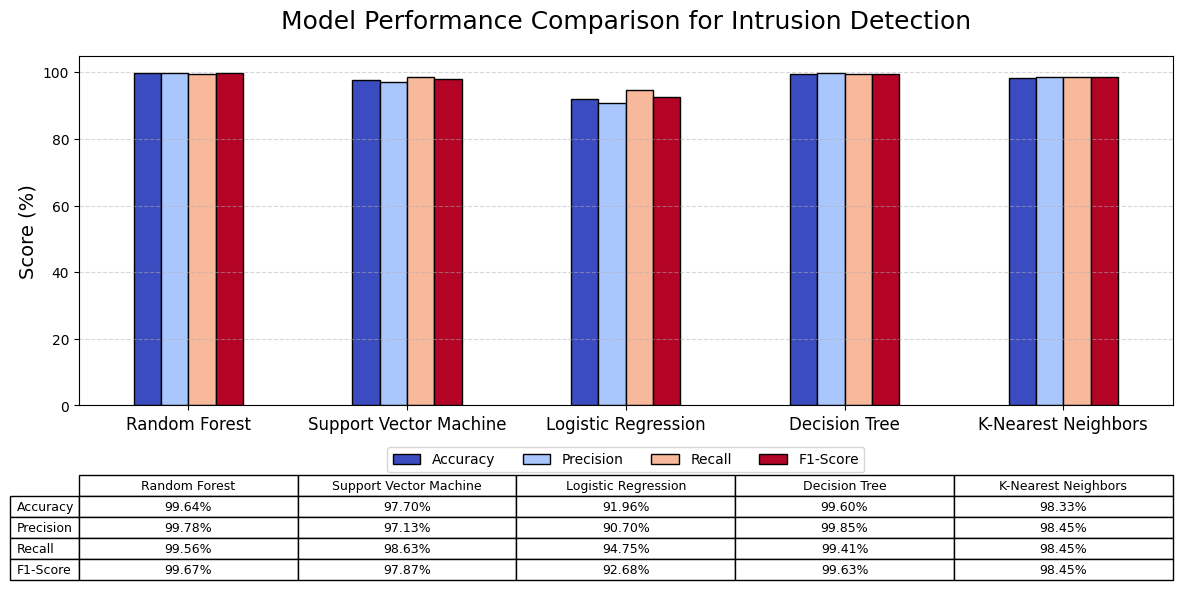

In [50]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

# Function to calculate performance metrics
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred) * 100  # Convert to percentage
    precision = precision_score(y_true, y_pred) * 100
    recall = recall_score(y_true, y_pred) * 100
    f1 = f1_score(y_true, y_pred) * 100
    return accuracy, precision, recall, f1

# Define models and their predictions
models = {
    'Random Forest': rfc_pred,
    'Support Vector Machine': svm_pred,
    'Logistic Regression': lrc_pred,
    'Decision Tree': dtc_pred,
    'K-Nearest Neighbors': knc_pred
}

# Calculate metrics for each model
results = []
for model_name, y_pred in models.items():
    accuracy, precision, recall, f1 = evaluate_model(y_test, y_pred)
    results.append([accuracy, precision, recall, f1])

# Convert results to a DataFrame (metrics as rows)
df_results = pd.DataFrame(results, index=models.keys(), columns=['Accuracy', 'Precision', 'Recall', 'F1-Score']).T

# Format all values to percentages with two decimal places
df_results = df_results.applymap(lambda x: f"{x:.2f}%")

# Convert to numeric for plotting (ignoring % symbols)
df_plot = df_results.replace({'%': ''}, regex=True).astype(float)

# Create figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot grouped bar chart
df_plot.T.plot(kind='bar', ax=ax, colormap="coolwarm", edgecolor="black")

# Formatting
plt.title("Model Performance Comparison for Intrusion Detection", fontsize=18, pad=20)
plt.ylabel("Score (%)", fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.legend(loc="upper center", ncol=4, fontsize=10, bbox_to_anchor=(0.5, -0.1))
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Add table below the graph
table_data = df_results.values
table = plt.table(cellText=table_data, rowLabels=df_results.index, colLabels=df_results.columns,
                  cellLoc='center', loc='bottom', bbox=[0, -0.5, 1, 0.3])

# Adjust layout to make space for the table
plt.subplots_adjust(bottom=0.3)

# Show plot
plt.tight_layout()
plt.show()

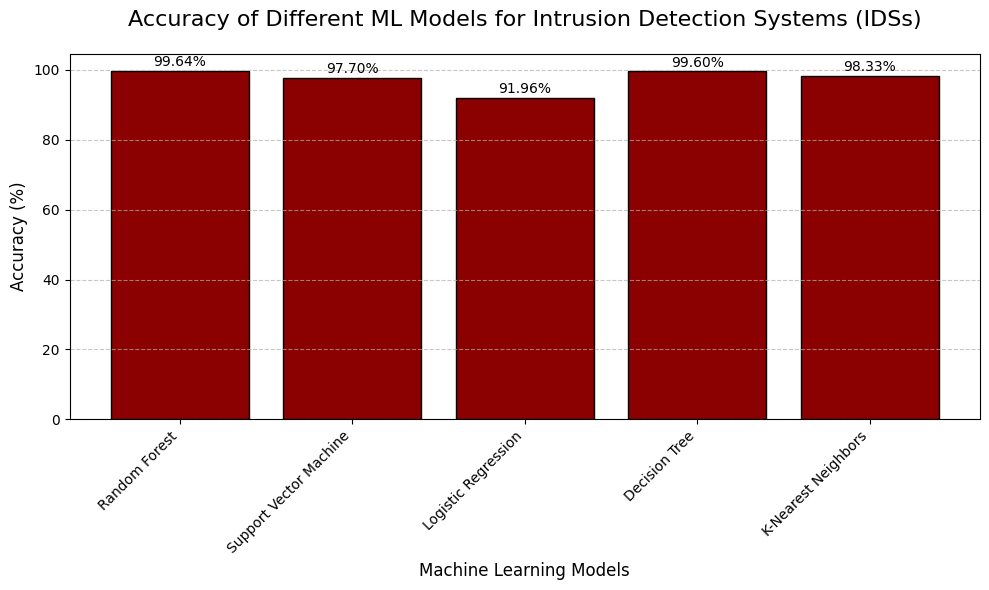

In [51]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score

# Function to calculate accuracy
def evaluate_accuracy(model_name, y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred) * 100  # Convert to percentage
    return accuracy

# Calculate accuracy for all models
models = {
    'Random Forest': rfc_pred,
    'Support Vector Machine': svm_pred,
    'Logistic Regression': lrc_pred,
    'Decision Tree': dtc_pred,
    'K-Nearest Neighbors': knc_pred
}

# Store results in a list
accuracy_results = []
for model_name, y_pred in models.items():
    accuracy = evaluate_accuracy(model_name, y_test, y_pred)
    accuracy_results.append([model_name, accuracy])

# Create a DataFrame
df_accuracy = pd.DataFrame(accuracy_results, columns=['Model', 'Accuracy (%)'])

# Plot the bar graph
plt.figure(figsize=(10, 6))  # Set figure size
bars = plt.bar(df_accuracy['Model'], df_accuracy['Accuracy (%)'], color='darkred', edgecolor='black')

# Add percentage labels above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X-position of the label
        height + 0.5,  # Y-position of the label (slightly above the bar)
        f'{height:.2f}%',  # Label text (accuracy value with 2 decimal places)
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=10
    )

# Add labels, title, and grid
plt.title('Accuracy of Different ML Models for Intrusion Detection Systems (IDSs)', fontsize=16, pad=20)
plt.xlabel('Machine Learning Models', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate model names for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

# Prediction for Testing Dataset
* Reading the Testing Dataset
* EDA
* Missing Values
* Duplicates
* Label Encoding
* Prediction of Test Data

**Reading the Testing Dataset**

In [52]:
test = pd.read_csv("/kaggle/input/network-intrusion-detection/Test_data.csv")

**EDA**

In [53]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22544 entries, 0 to 22543
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     22544 non-null  int64  
 1   protocol_type                22544 non-null  object 
 2   service                      22544 non-null  object 
 3   flag                         22544 non-null  object 
 4   src_bytes                    22544 non-null  int64  
 5   dst_bytes                    22544 non-null  int64  
 6   land                         22544 non-null  int64  
 7   wrong_fragment               22544 non-null  int64  
 8   urgent                       22544 non-null  int64  
 9   hot                          22544 non-null  int64  
 10  num_failed_logins            22544 non-null  int64  
 11  logged_in                    22544 non-null  int64  
 12  num_compromised              22544 non-null  int64  
 13  root_shell      

In [54]:
test.shape

(22544, 41)

In [55]:
test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,tcp,private,REJ,0,0,0,0,0,0,...,255,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00
1,0,tcp,private,REJ,0,0,0,0,0,0,...,255,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,134,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,3,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,29,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71


In [56]:
test.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,22544.000000,2.254400e+04,2.254400e+04,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,...,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000
mean,218.859076,1.039545e+04,2.056019e+03,0.000311,0.008428,0.000710,0.105394,0.021647,0.442202,0.119899,...,193.869411,140.750532,0.608722,0.090540,0.132261,0.019638,0.097814,0.099426,0.233385,0.226683
std,1407.176612,4.727864e+05,2.121930e+04,0.017619,0.142599,0.036473,0.928428,0.150328,0.496659,7.269597,...,94.035663,111.783972,0.435688,0.220717,0.306268,0.085394,0.273139,0.281866,0.387229,0.400875
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,121.000000,15.000000,0.070000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.400000e+01,4.600000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,168.000000,0.920000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.870000e+02,6.010000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.060000,0.030000,0.010000,0.000000,0.000000,0.360000,0.170000
max,57715.000000,6.282565e+07,1.345927e+06,1.000000,3.000000,3.000000,101.000000,4.000000,1.000000,796.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [57]:
test['num_outbound_cmds']

0        0
1        0
2        0
3        0
4        0
        ..
22539    0
22540    0
22541    0
22542    0
22543    0
Name: num_outbound_cmds, Length: 22544, dtype: int64

In [58]:
#Drop the redundant feature
test.drop(['num_outbound_cmds'], axis=1, inplace=True)

**Missing Values**

In [59]:
test.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_host_rate             0
dst_host_c

**Duplicates**

In [60]:
print(f"Number of duplicates: {test.duplicated().sum()}")

Number of duplicates: 57


In [61]:
test.drop_duplicates(inplace=True)

In [62]:
test.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,22487.000000,2.248700e+04,2.248700e+04,22487.000000,22487.000000,22487.000000,22487.000000,22487.000000,22487.000000,22487.000000,...,22487.000000,22487.000000,22487.000000,22487.000000,22487.000000,22487.000000,22487.000000,22487.000000,22487.000000,22487.000000
mean,219.413839,1.042155e+04,2.060921e+03,0.000311,0.008449,0.000712,0.105661,0.021701,0.443323,0.120203,...,193.720861,140.504380,0.607873,0.090617,0.132586,0.019688,0.098056,0.099678,0.233848,0.227124
std,1408.915818,4.733850e+05,2.124595e+04,0.017641,0.142779,0.036519,0.929589,0.150514,0.496788,7.278803,...,94.103599,111.779078,0.435770,0.220709,0.306588,0.085496,0.273442,0.282179,0.387459,0.401129
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,120.000000,15.000000,0.070000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.400000e+01,4.600000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,166.000000,0.920000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.870000e+02,6.080000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.060000,0.030000,0.010000,0.000000,0.000000,0.360000,0.170000
max,57715.000000,6.282565e+07,1.345927e+06,1.000000,3.000000,3.000000,101.000000,4.000000,1.000000,796.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [63]:
test.describe(include='object')

,protocol_type,service,flag
count,22487,22487,22487
unique,3,64,11
top,tcp,http,SF
freq,18877,7853,14821


**Label Encoding**

In [65]:
le(test)

In [66]:
test

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,1,45,1,0,0,0,0,0,0,...,255,10,0.04,0.06,0.00,0.00,0.00,0.0,1.00,1.00
1,0,1,45,1,0,0,0,0,0,0,...,255,1,0.00,0.06,0.00,0.00,0.00,0.0,1.00,1.00
2,2,1,19,9,12983,0,0,0,0,0,...,134,86,0.61,0.04,0.61,0.02,0.00,0.0,0.00,0.00
3,0,0,13,9,20,0,0,0,0,0,...,3,57,1.00,0.00,1.00,0.28,0.00,0.0,0.00,0.00
4,1,1,55,2,0,15,0,0,0,0,...,29,86,0.31,0.17,0.03,0.02,0.00,0.0,0.83,0.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,1,49,9,794,333,0,0,0,0,...,100,141,0.72,0.06,0.01,0.01,0.01,0.0,0.00,0.00
22540,0,1,22,9,317,938,0,0,0,0,...,197,255,1.00,0.00,0.01,0.01,0.01,0.0,0.00,0.00
22541,0,1,22,9,54540,8314,0,0,0,2,...,255,255,1.00,0.00,0.00,0.00,0.00,0.0,0.07,0.07
22542,0,2,11,9,42,42,0,0,0,0,...,255,252,0.99,0.01,0.00,0.00,0.00,0.0,0.00,0.00


**Prediction of Test Data**

In [68]:
X = test[selected_features]
scale = StandardScaler()
X_scaled = scale.fit_transform(X)

In [69]:
rfc.predict(X_scaled)

array([0, 0, 1, ..., 1, 1, 0])

In [70]:
lrc.predict(X_scaled)

array([0, 0, 1, ..., 1, 1, 0])

In [71]:
dtc.predict(X_scaled)

array([0, 0, 1, ..., 1, 0, 1])

In [72]:
knc.predict(X_scaled)

array([0, 0, 1, ..., 1, 1, 0])

In [73]:
svm.predict(X_scaled)

array([0, 0, 1, ..., 0, 1, 0])